In [1]:
!pip install sklearn

In [2]:
# #Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

data = pd.read_csv(r'D:\msc-project\from-github\dissertations-2021-info\rahim_ghani_predict\data\features_with_outcome.csv',
                   encoding='utf=8',
                  index_col='org_uuid')
target = 'outcome'

In [3]:
from sklearn.model_selection import train_test_split

y_data = data['outcome']
X_data = data.drop(columns=['outcome'])

X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,stratify=y_data)

In [4]:
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [5]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['outcome'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtest_predictions = alg.predict(dtest[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Training Accuracy : %.4g" % metrics.accuracy_score(dtrain['outcome'].values, dtrain_predictions))
    print ("Test Accuracy : %.4g" % metrics.accuracy_score(dtest['outcome'].values, dtest_predictions))
    print ("Training Precision : %.4g" % metrics.precision_score(dtrain['outcome'].values, dtrain_predictions))
    print ("Test Precision : %.4g" % metrics.precision_score(dtest['outcome'].values, dtest_predictions))
    print ("Training Recall : %.4g" % metrics.recall_score(dtrain['outcome'].values, dtrain_predictions))
    print ("Test Recall : %.4g" % metrics.recall_score(dtest['outcome'].values, dtest_predictions))
    print ("Training f1 : %.4g" % metrics.f1_score(dtrain['outcome'].values, dtrain_predictions))
    print ("Test f1 : %.4g" % metrics.f1_score(dtest['outcome'].values, dtest_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['outcome'], dtrain_predprob))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(dtest['outcome'], dtest_predprob))
    print ("Training Set Confusion Matrix\n")
    print (metrics.confusion_matrix(dtrain['outcome'],dtrain_predictions))
    print ("Test Set Confusion Matrix\n")
    print (metrics.confusion_matrix(dtest['outcome'],dtest_predictions))
                    
    feat_imp = pd.Series(alg.feature_importances_,index=predictors).sort_values(ascending=False).nlargest(n=20)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [6]:
#specify parameters taken from autosklearn: Gradient boosting with f1 as target metric
early_stop = 'valid'
l2_regularization = 0.017722562473527163
learning_rate = 0.04226227092427818
loss = 'auto'
max_bins = 255
max_depth = None
max_leaf_nodes = 15
min_sample_leaf = 22
scoring = 'loss'
tol = 1**(-7)
n_iter_no_change = 6

In [7]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]

C:\Users\Abdul Rahim Ab Ghani\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Training Accuracy : 0.832
Test Accuracy : 0.786
Training Precision : 0.8369
Test Precision : 0.5967
Training Recall : 0.3421
Test Recall : 0.2372
Training f1 : 0.4856
Test f1 : 0.3395
AUC Score (Train): 0.831431
AUC Score (Test): 0.755331
Training Set Confusion Matrix

[[16216   333]
 [ 3287  1709]]
Test Set Confusion Matrix

[[5250  267]
 [1270  395]]


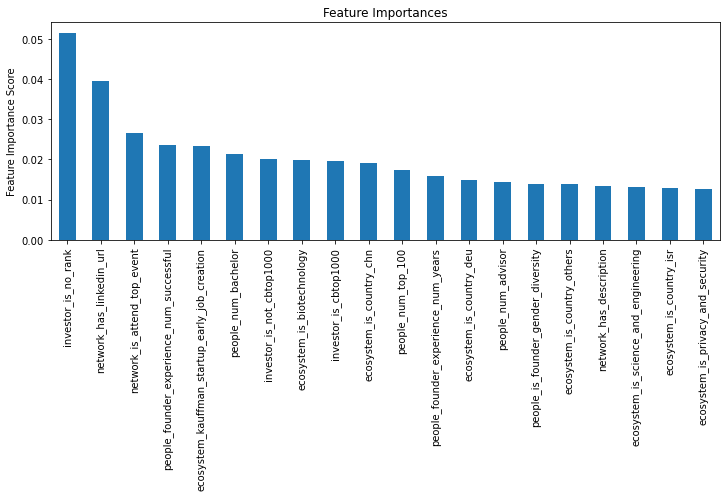

In [8]:
xgb1 = XGBClassifier(
        learning_rate =learning_rate,
        reg_lambda = l2_regularization,
        max_depth=6,
        min_child_weight=1,
        n_estimators=1000,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27
)

modelfit(xgb1, train, test, predictors)

In [ ]:
#Tune scale_pos_weight
param_test1 = {
    'scale_pos_weight':range(0,10,2)    
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =learning_rate,
                                                reg_lambda = l2_regularization,
                                                max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=1000,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27), 
                        param_grid = param_test1, scoring='f1',n_jobs=4, cv=5)

gsearch1.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch1.cv_results_))
print(gsearch1.best_params_)
print(gsearch1.best_score_)

In [ ]:
#Tune scale_pos_weight
param_test1a = {
    'scale_pos_weight':[3,4,5]    
}
gsearch1a = GridSearchCV(estimator = XGBClassifier(learning_rate =learning_rate,
                                                reg_lambda = l2_regularization,
                                                max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=1000,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=4,
                                                seed=27), 
                        param_grid = param_test1a, scoring='f1',n_jobs=4, cv=5)

gsearch1a.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch1a.cv_results_))
print(gsearch1a.best_params_)
print(gsearch1a.best_score_)

In [ ]:
param_test2 = {
 'max_depth':range(0,10,2),
 'min_child_weight':range (1,5,1)
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=140, 
                                                  max_depth=9,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=4,
                                                  seed=27), 
                        param_grid = param_test2, scoring='f1',n_jobs=4, cv=5)

gsearch2.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch2.cv_results_))
print(gsearch2.best_params_)
print(gsearch2.best_score_)

In [ ]:
param_test2a = {
    'max_depth':[3,4,5],
    'min_child_weight':[1,2,3]
}

gsearch2a = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=140, 
                                                  max_depth=4,
                                                  min_child_weight=2, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=4,
                                                  seed=27), 
                        param_grid = param_test2a, scoring='f1',n_jobs=4, cv=5)

gsearch2a.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch2a.cv_results_))
print(gsearch2a.best_params_)
print(gsearch2a.best_score_)

In [ ]:
xgb2 = XGBClassifier(
        learning_rate =learning_rate,
        reg_lambda = l2_regularization,
        max_depth=4,
        min_child_weight=2,
        n_estimators=1000,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=4,
        seed=27
)

modelfit(xgb2, train, test, predictors)

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=4,
                                                  min_child_weight=2, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=4,
                                                  seed=27), 
                        param_grid = param_test3, scoring='f1',n_jobs=4, cv=5)

gsearch3.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch3.cv_results_))
print(gsearch3.best_params_)
print(gsearch3.best_score_)

In [ ]:
param_test3a = {
 'gamma':[i/100.0 for i in range(20,30)]
}

gsearch3a = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=4,
                                                  min_child_weight=2, 
                                                  gamma=0.2, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=4,
                                                  seed=27), 
                        param_grid = param_test3a, scoring='f1',n_jobs=4, cv=5)

gsearch3a.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch3a.cv_results_))
print(gsearch3a.best_params_)
print(gsearch3a.best_score_)

In [ ]:
param_test3b = {
 'gamma':[i/100.0 for i in range(10,20)]
}

gsearch3b = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=140, 
                                                  max_depth=4,
                                                  min_child_weight=2, 
                                                  gamma=0.2, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=4,
                                                  seed=27), 
                        param_grid = param_test3b, scoring='f1',n_jobs=4, cv=5)

gsearch3b.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch3b.cv_results_))
print(gsearch3b.best_params_)
print(gsearch3b.best_score_)

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=140, 
                                                  max_depth=4,
                                                  min_child_weight=2, 
                                                  gamma=0.13, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=4,
                                                  seed=27), 
                        param_grid = param_test4, scoring='f1',n_jobs=4, cv=5)

gsearch4.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch4.cv_results_))
print(gsearch4.best_params_)
print(gsearch4.best_score_)

In [ ]:
param_test4a = {
 'colsample_bytree':[i/100.0 for i in range(80,90)]
}

gsearch4a = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=140, 
                                                  max_depth=4,
                                                  min_child_weight=2, 
                                                  gamma=0.13, 
                                                  subsample=0.9, 
                                                  colsample_bytree=0.9,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=4,
                                                  seed=27), 
                        param_grid = param_test4a, scoring='f1',n_jobs=4, cv=5)

gsearch4a.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch4a.cv_results_))
print(gsearch4a.best_params_)
print(gsearch4a.best_score_)

In [ ]:
param_test5 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=140, 
                                                  max_depth=4,
                                                  min_child_weight=2, 
                                                  gamma=0.13, 
                                                  subsample=0.9, 
                                                  colsample_bytree=0.87,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=4,
                                                  seed=27), 
                        param_grid = param_test5, scoring='f1',n_jobs=4, cv=5)

gsearch5.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch5.cv_results_))
print(gsearch5.best_params_)
print(gsearch5.best_score_)

C:\Users\Abdul Rahim Ab Ghani\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Training Accuracy : 0.7071
Test Accuracy : 0.6688
Training Precision : 0.4269
Test Precision : 0.3845
Training Recall : 0.7682
Test Recall : 0.7135
Training f1 : 0.5488
Test f1 : 0.4997
AUC Score (Train): 0.808713
AUC Score (Test): 0.751538
Training Set Confusion Matrix

[[11396  5153]
 [ 1158  3838]]
Test Set Confusion Matrix

[[3615 1902]
 [ 477 1188]]


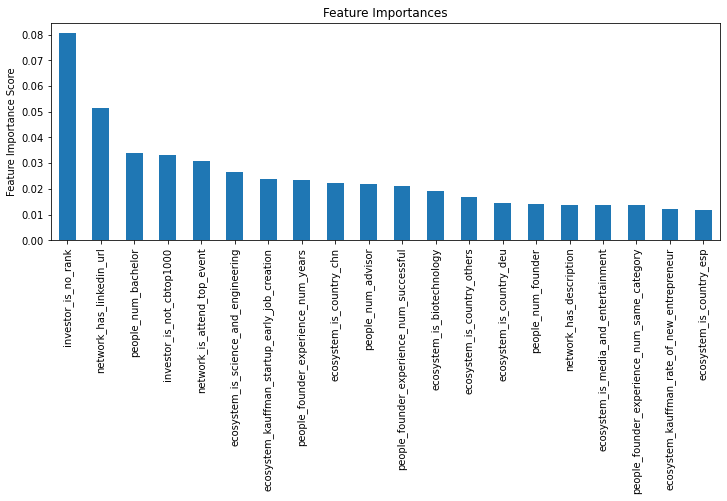

In [7]:
xgb3 = XGBClassifier(
        learning_rate =learning_rate,
        reg_lambda = l2_regularization,
        reg_alpha = 0.005,
        max_depth=4,
        min_child_weight=2,
        n_estimators=1000,
        gamma=0.13,
        subsample=0.9,
        colsample_bytree=0.87,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=4,
        seed=27
)

modelfit(xgb3, train, test, predictors)

In [ ]:
param_test7 = {
 'reg_lambda':[0,0.5,1,1.5,2.0]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =learning_rate,
                                                    reg_lambda = 1,
                                                    reg_alpha = 0.005,
                                                    max_depth=4,
                                                    min_child_weight=2,
                                                    n_estimators=1000,
                                                    gamma=0.13,
                                                    subsample=0.9,
                                                    colsample_bytree=0.87,
                                                    objective= 'binary:logistic',
                                                    nthread=4,
                                                    scale_pos_weight=4,
                                                    seed=27), 
                        param_grid = param_test7, scoring='f1',n_jobs=4, cv=5)

gsearch7.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch7.cv_results_))
print(gsearch7.best_params_)
print(gsearch7.best_score_)

In [ ]:
param_test7a = {
 'reg_lambda':[1.8,1.9,2.0,2.1,2.2]
}

gsearch7a = GridSearchCV(estimator = XGBClassifier(learning_rate =learning_rate,
                                                    reg_lambda = 2.0,
                                                    reg_alpha = 0.005,
                                                    max_depth=4,
                                                    min_child_weight=2,
                                                    n_estimators=1000,
                                                    gamma=0.13,
                                                    subsample=0.9,
                                                    colsample_bytree=0.87,
                                                    objective= 'binary:logistic',
                                                    nthread=4,
                                                    scale_pos_weight=4,
                                                    seed=27,
                                                      max_delta_step=1), 
                        param_grid = param_test7a, scoring='f1',n_jobs=4, cv=5)

gsearch7a.fit(train[predictors],train[target])

print(pd.DataFrame(gsearch7a.cv_results_))
print(gsearch7a.best_params_)
print(gsearch7a.best_score_)

In [ ]:
xgb4 = XGBClassifier(
        learning_rate =learning_rate,
        n_estimators=1000,
        reg_alpha = 0.005,
        reg_lambda = 1.8,
        max_depth=4,
        min_child_weight=2,
        gamma=0.13,
        subsample=0.9,
        colsample_bytree=0.87,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=4,
        seed=27,
        max_delta_step=1,
)

modelfit(xgb4, train, test, predictors)

In [ ]:
xgb5 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=5000,
        reg_lambda = 1.8,
        reg_alpha = 0.005,
        max_depth=4,
        min_child_weight=2,
        gamma=0.13,
        subsample=0.9,
        colsample_bytree=0.87,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=4,
        seed=27,
        max_delta_step=1,
)

modelfit(xgb5, train, test, predictors)

# Features Intrepretation

In [8]:
import shap

In [9]:
shap.initjs()

In [35]:
explainer = shap.TreeExplainer(xgb3)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


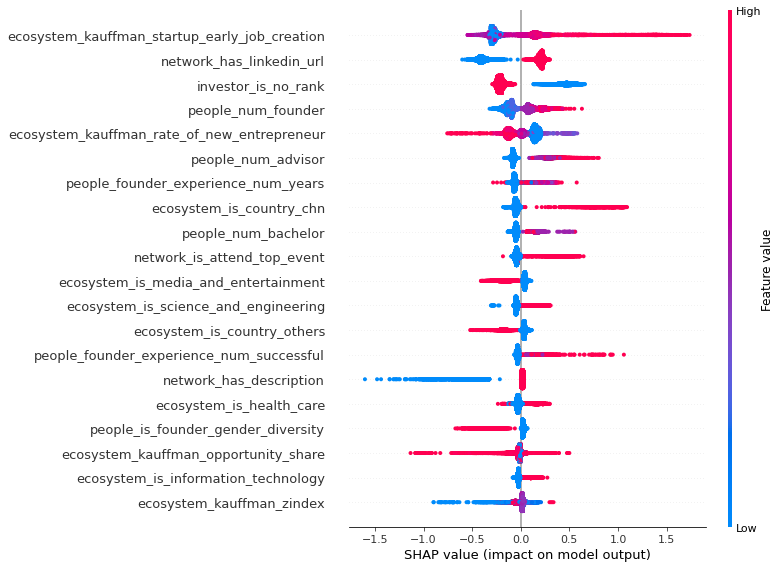

In [71]:
shap.summary_plot(shap_values,max_display=20)

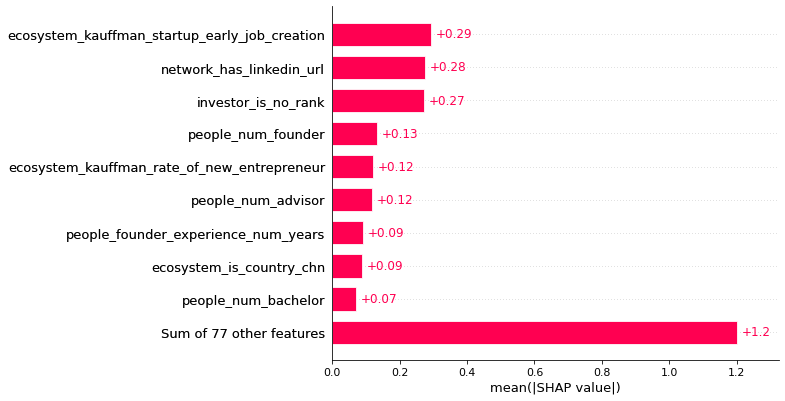

In [72]:
shap.plots.bar(shap_values)

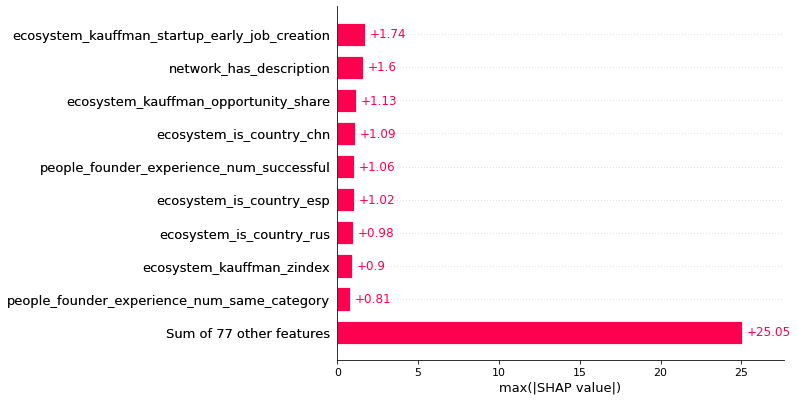

In [69]:
shap.plots.bar(shap_values.abs.max(0))

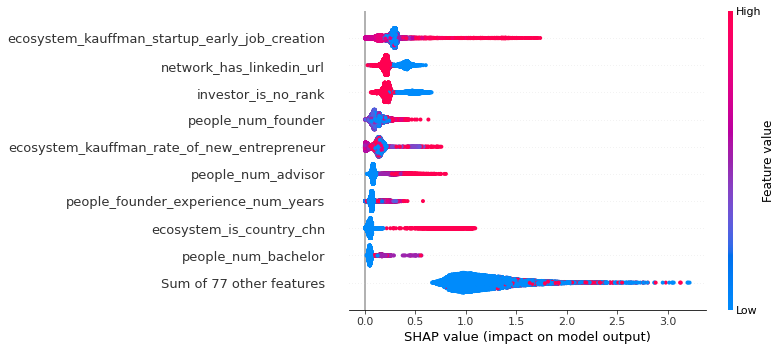

In [73]:
shap.plots.beeswarm(shap_values.abs)

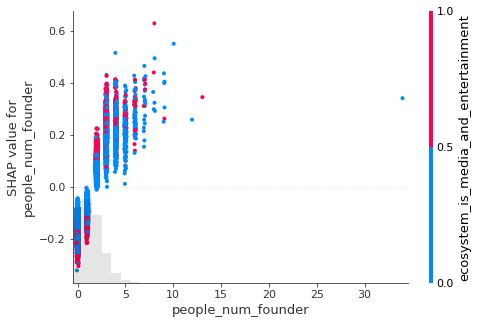

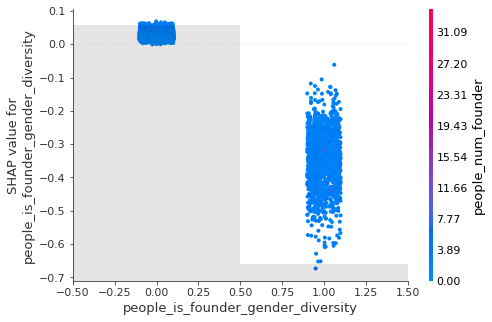

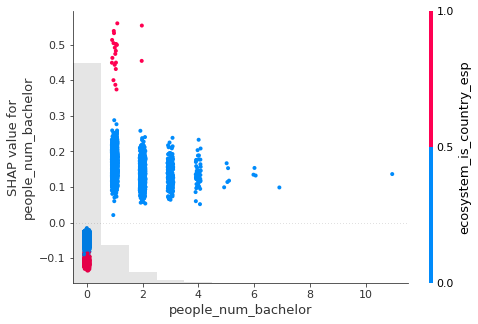

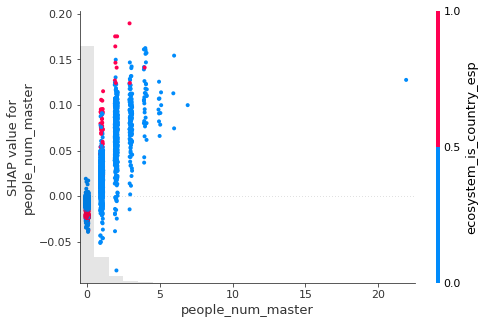

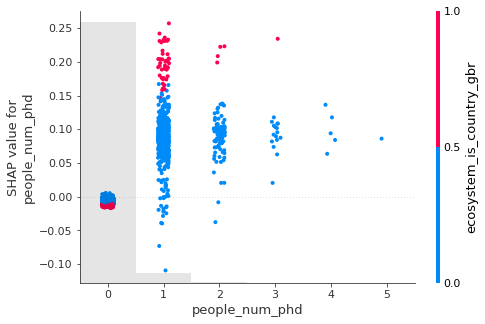

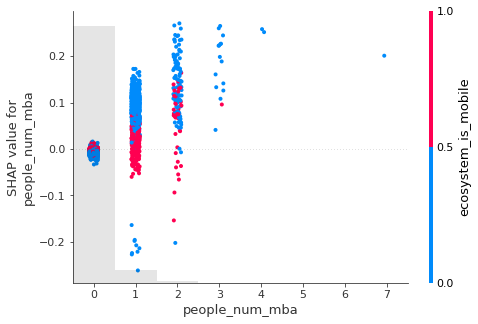

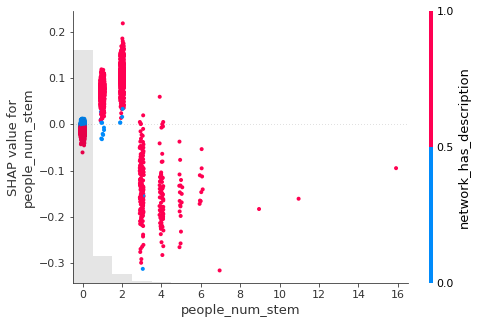

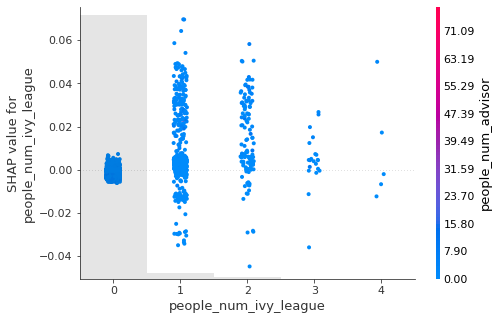

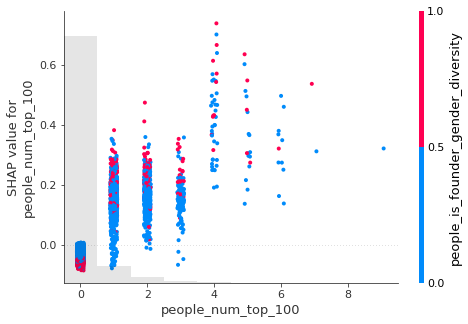

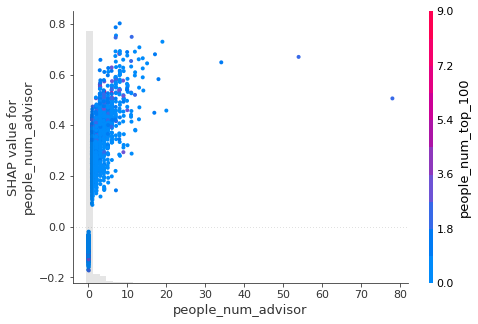

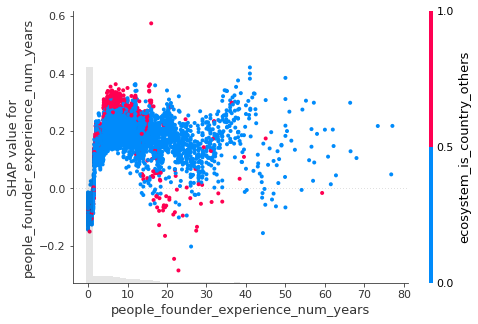

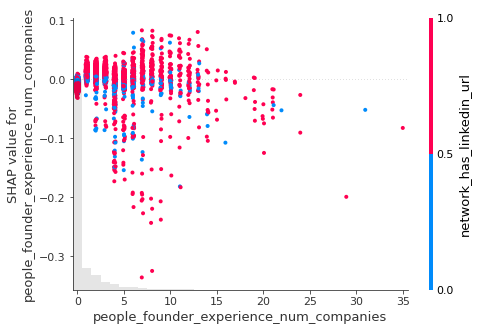

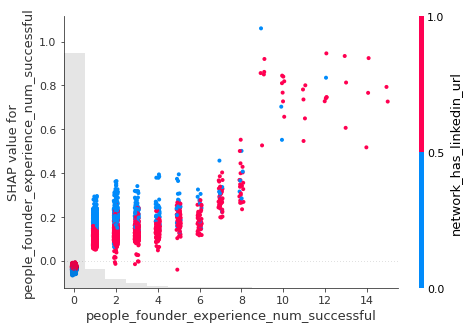

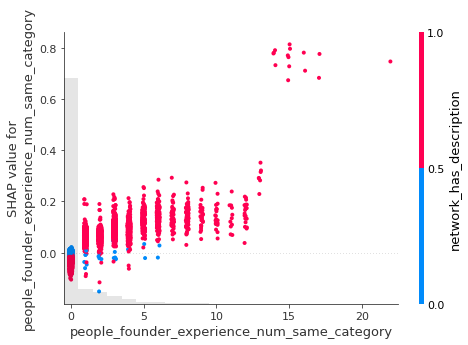

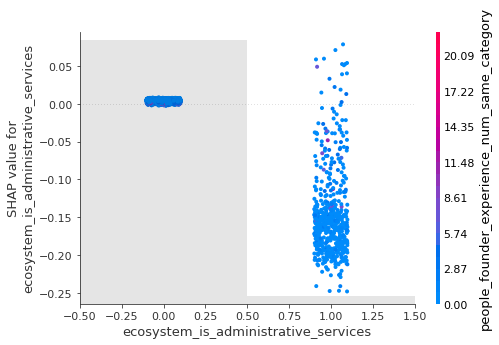

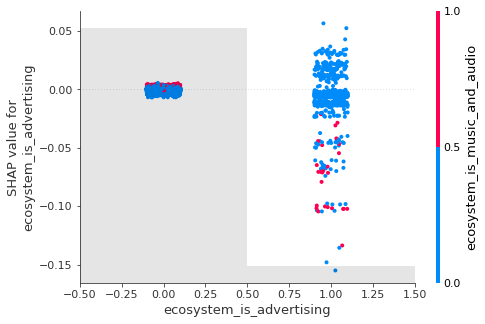

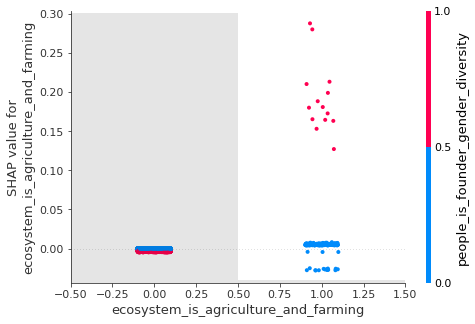

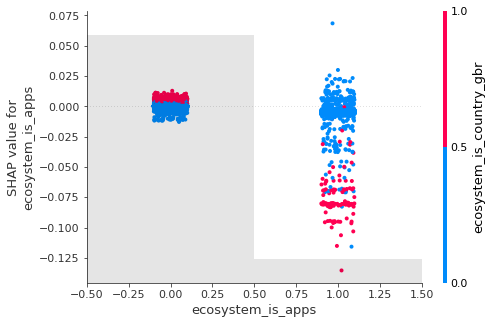

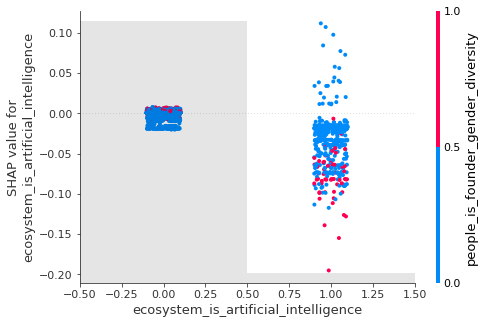

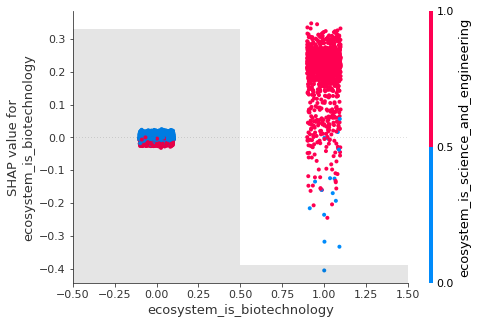

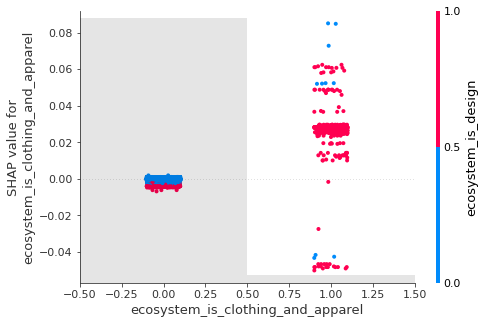

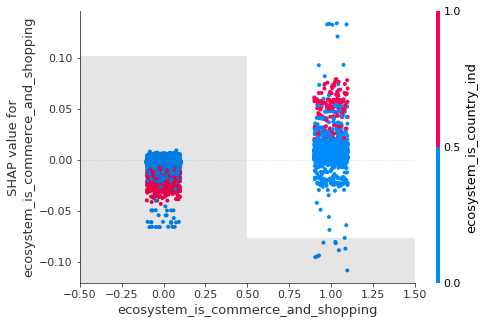

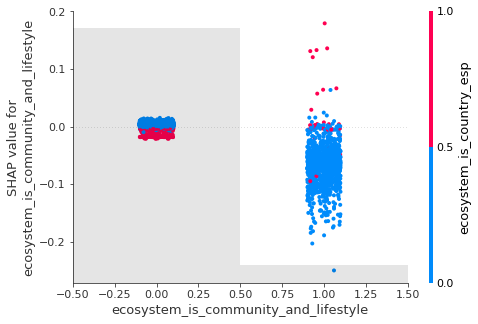

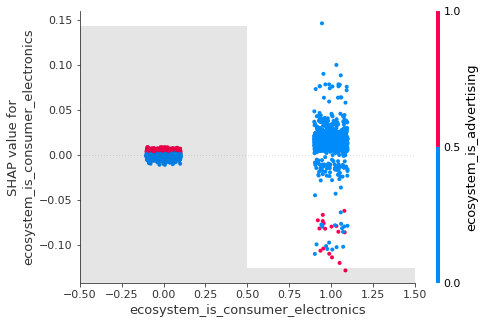

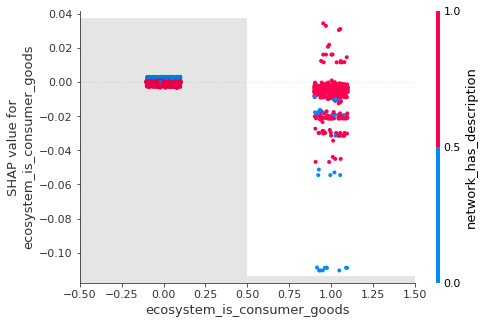

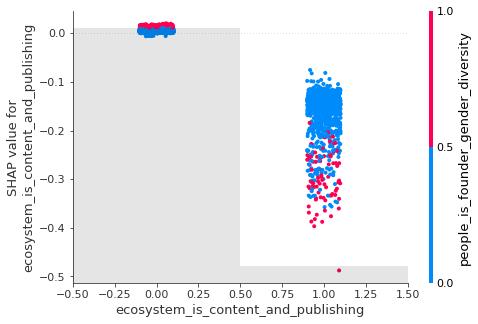

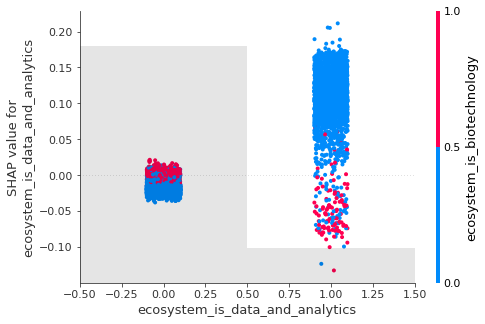

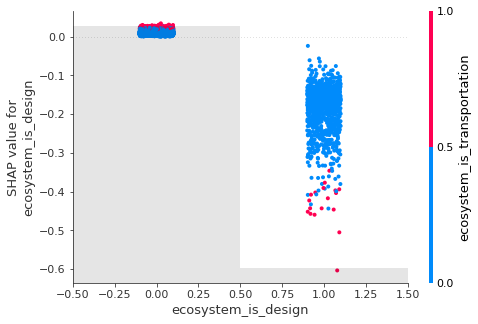

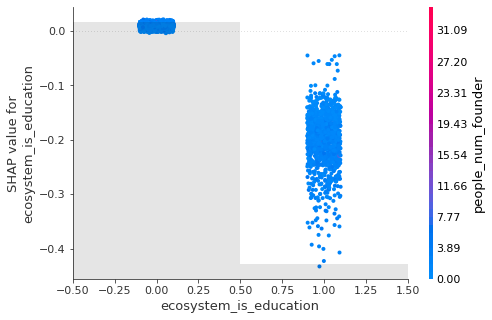

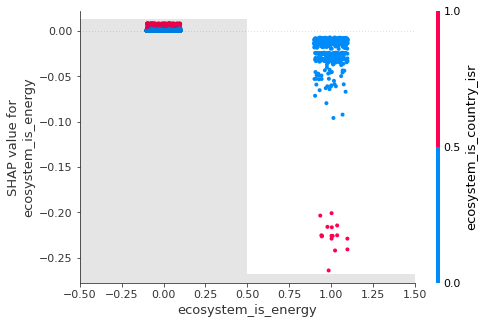

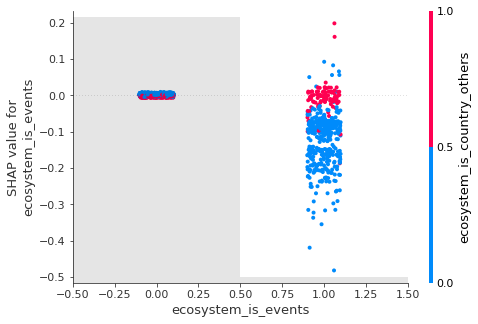

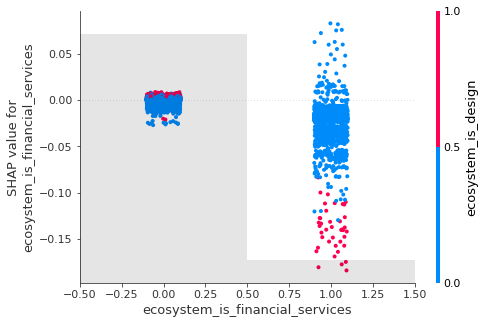

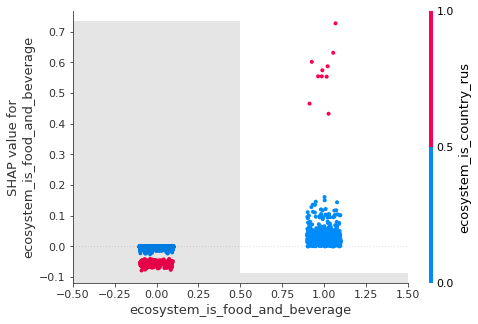

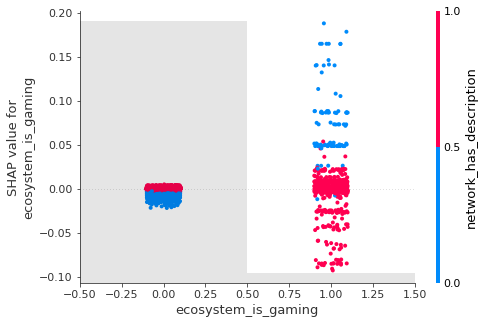

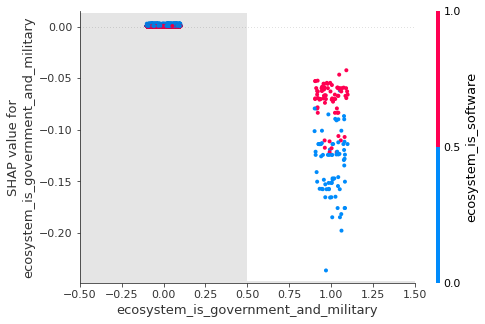

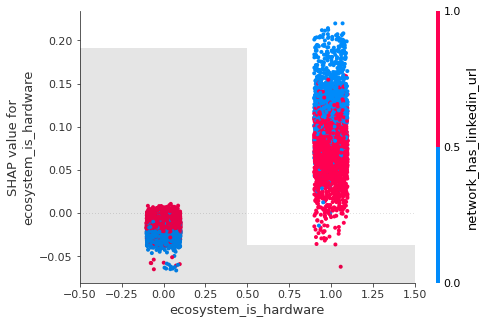

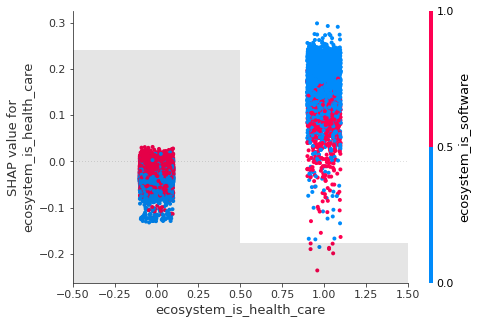

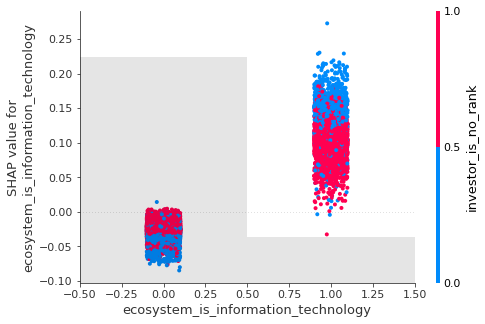

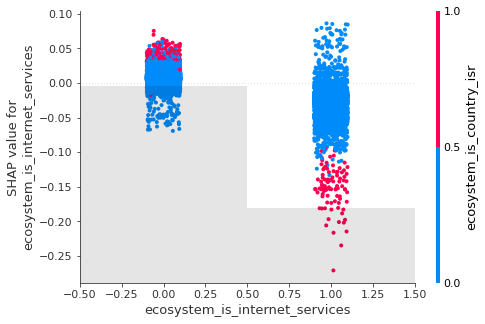

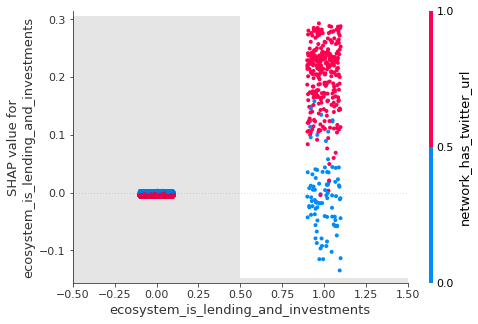

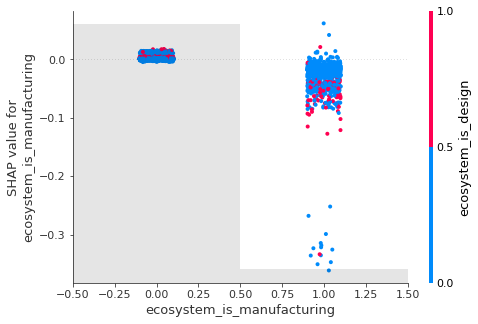

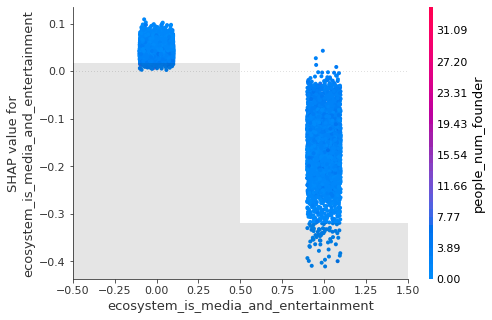

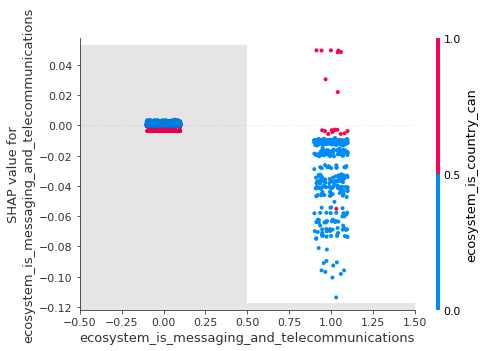

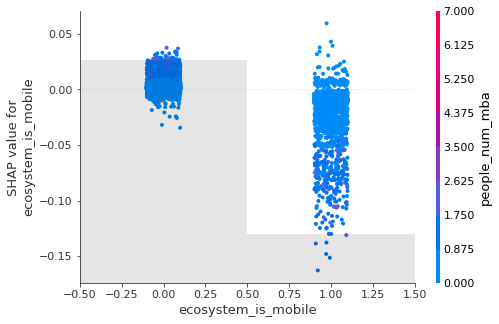

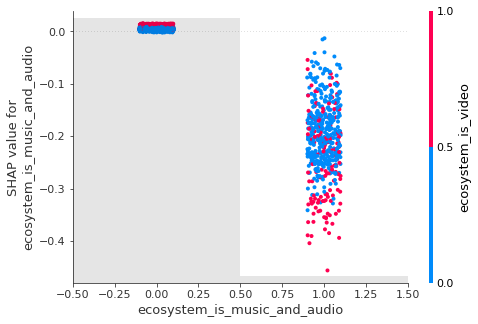

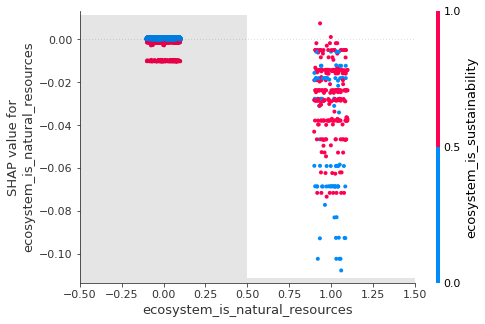

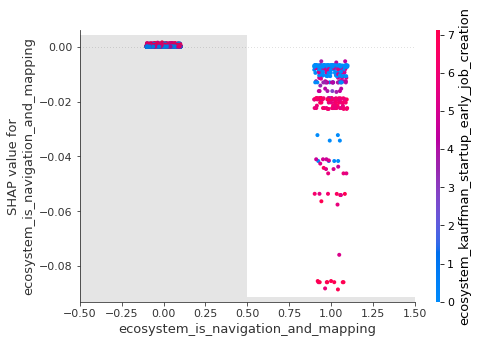

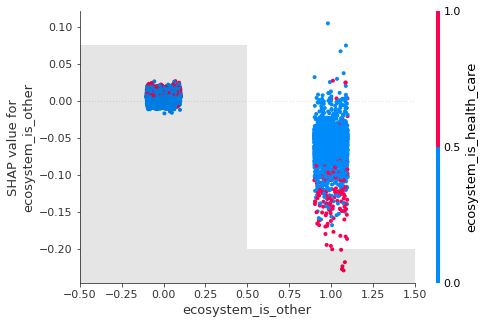

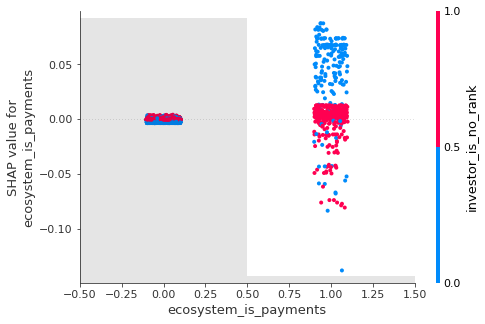

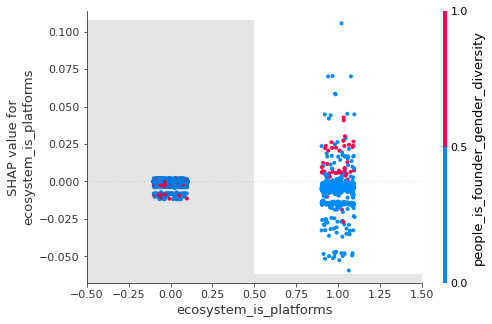

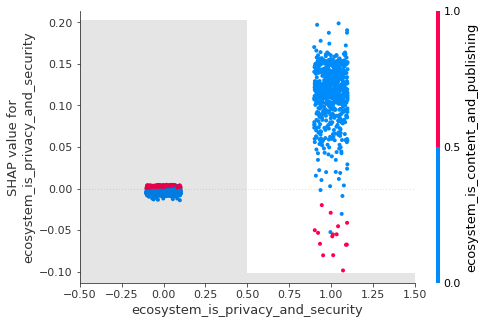

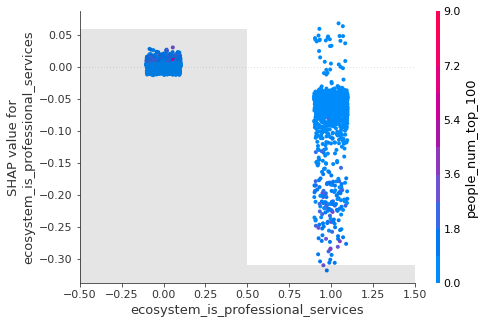

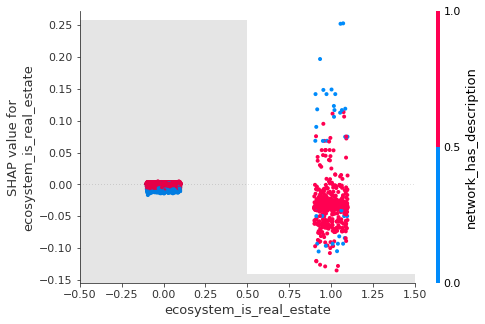

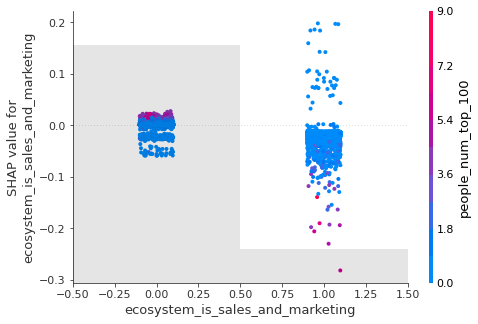

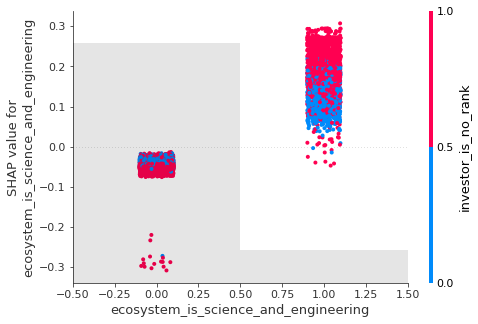

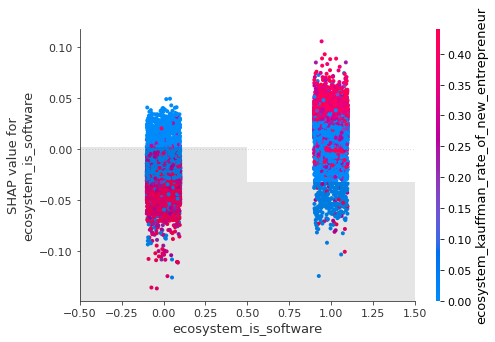

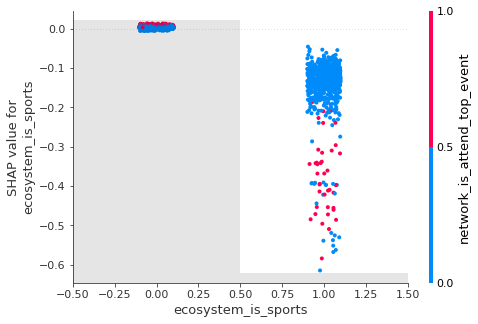

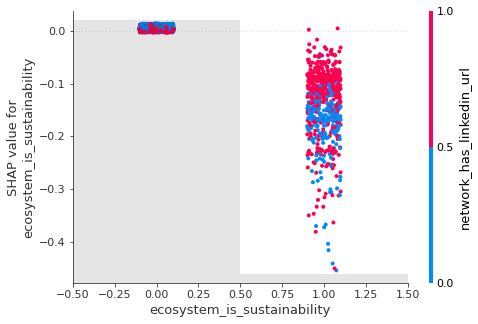

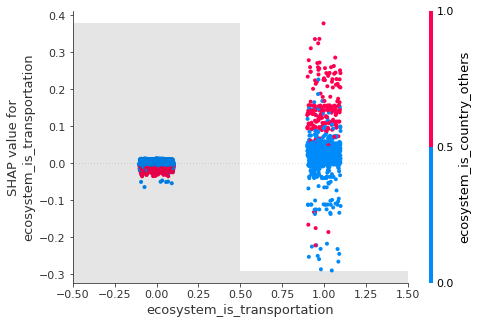

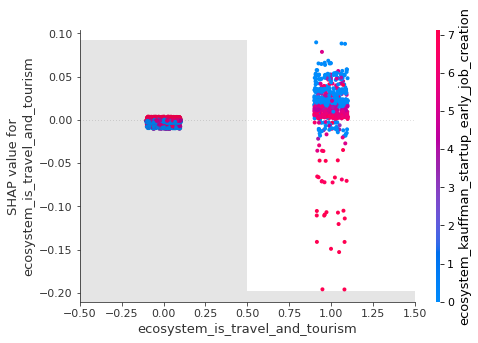

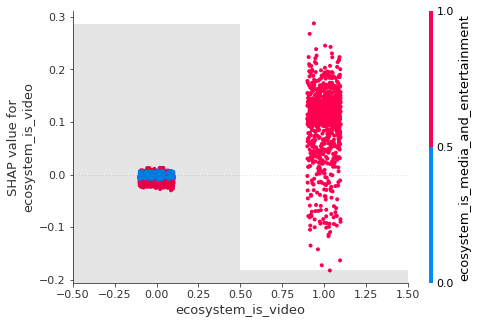

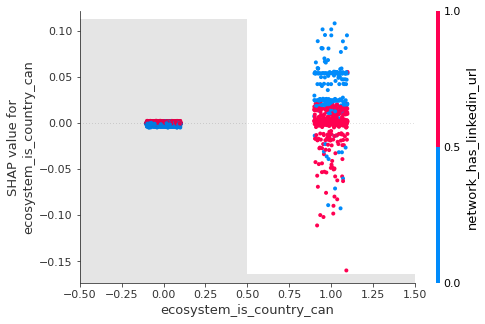

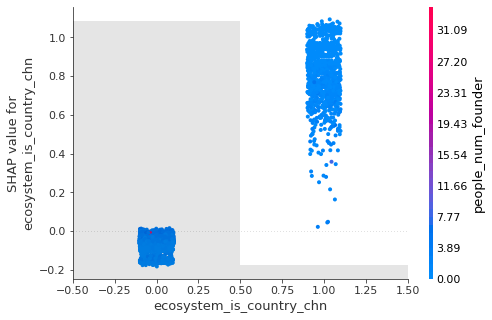

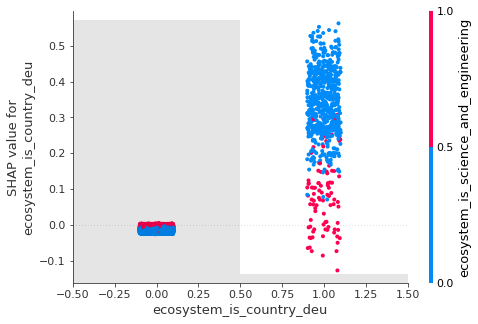

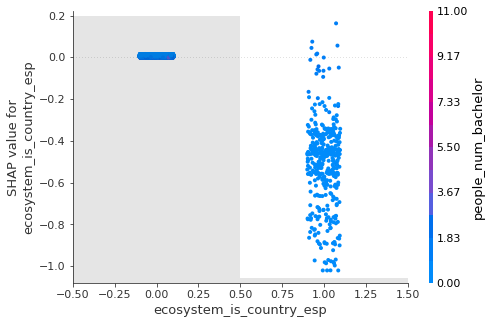

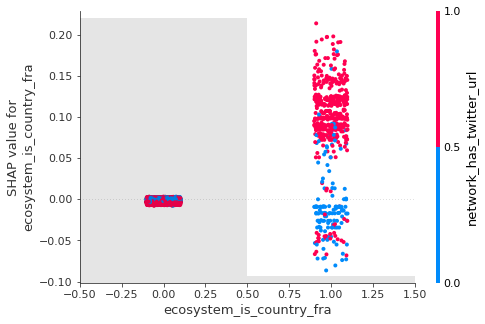

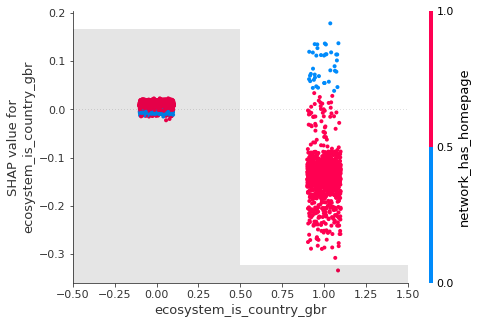

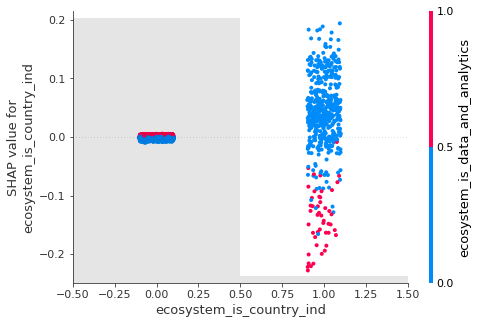

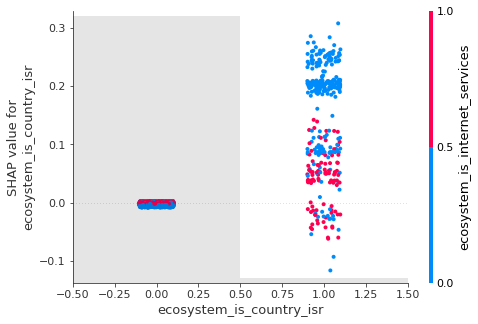

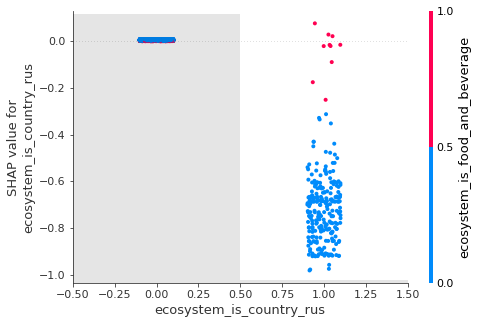

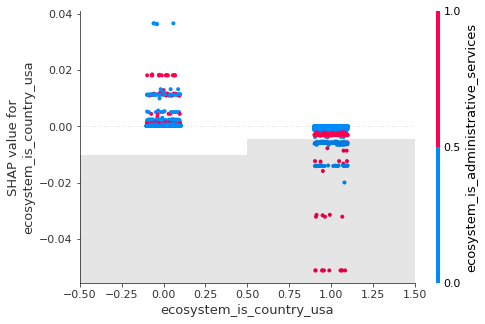

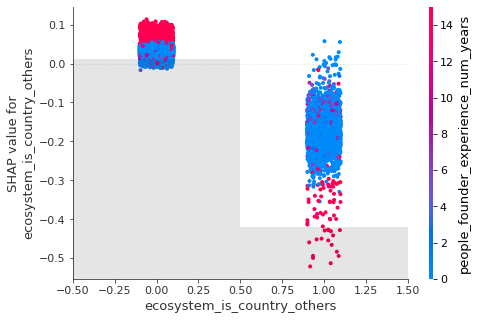

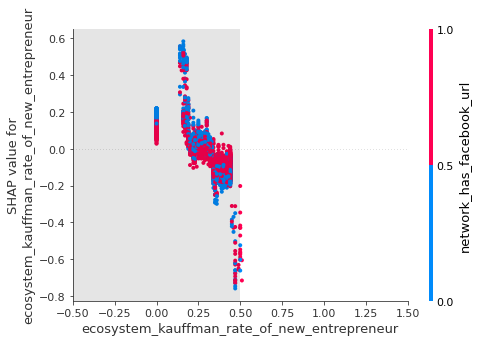

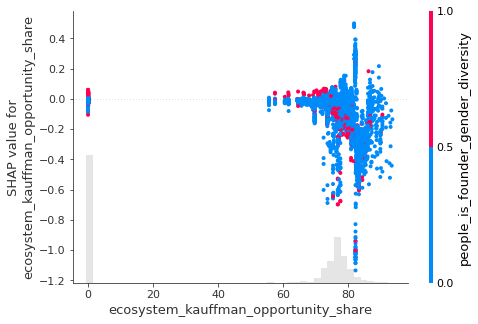

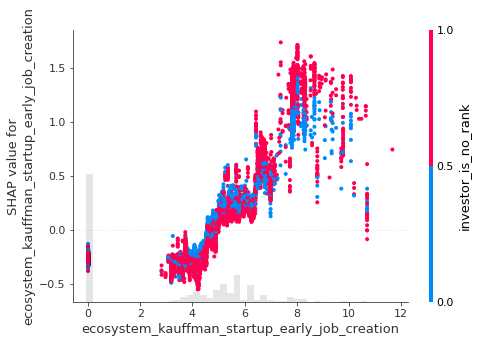

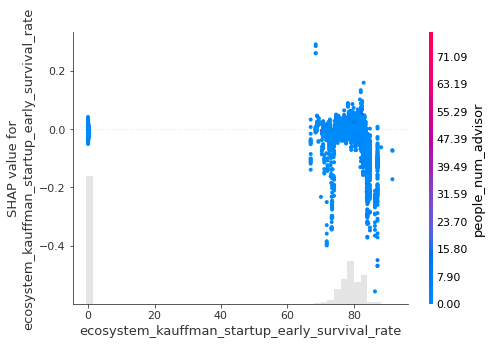

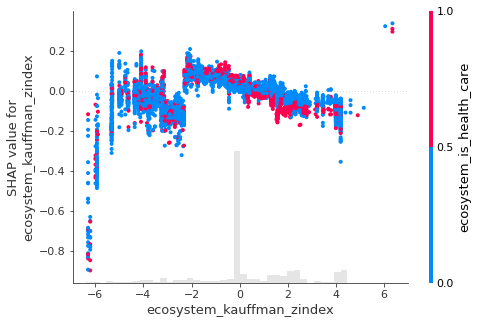

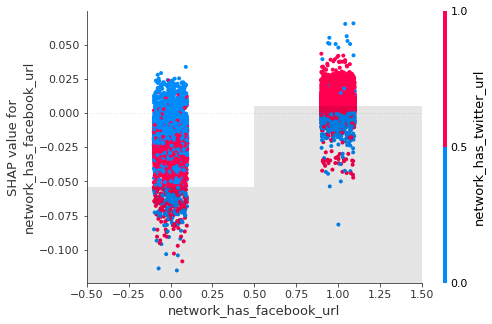

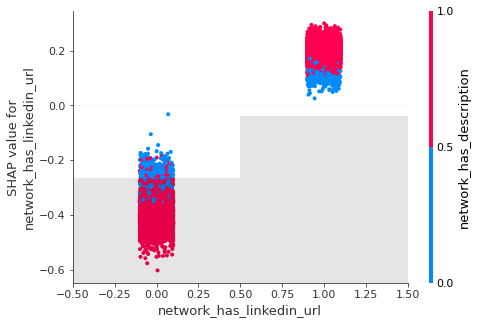

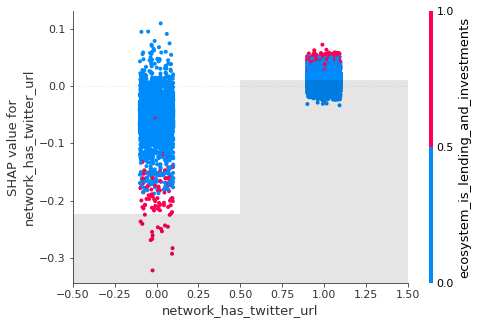

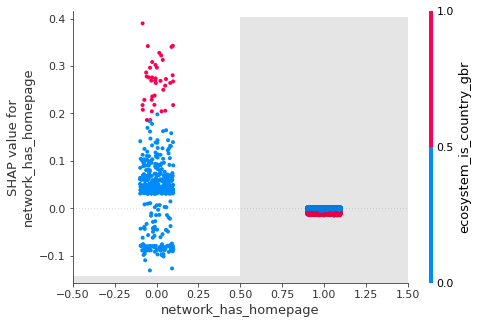

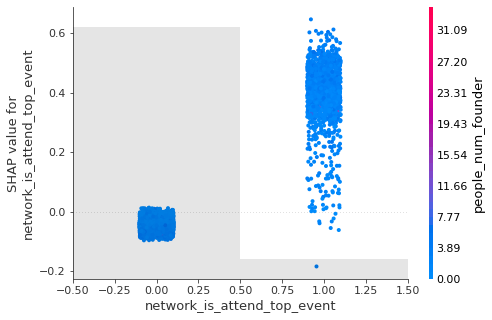

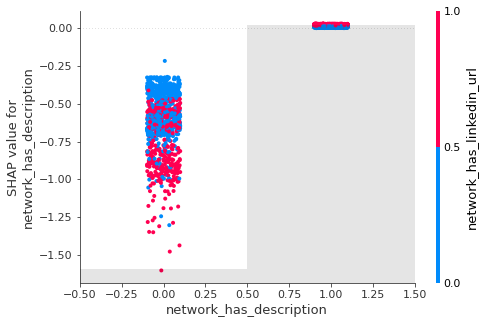

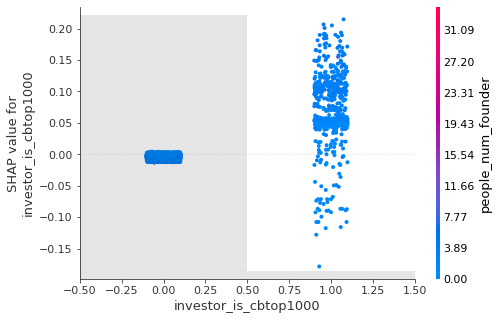

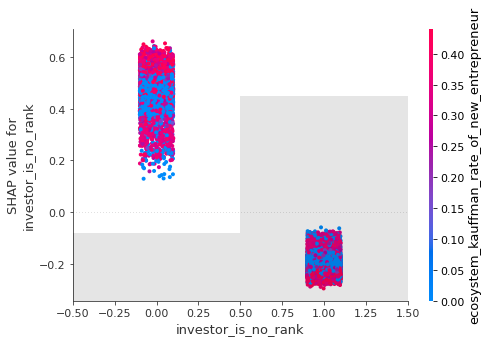

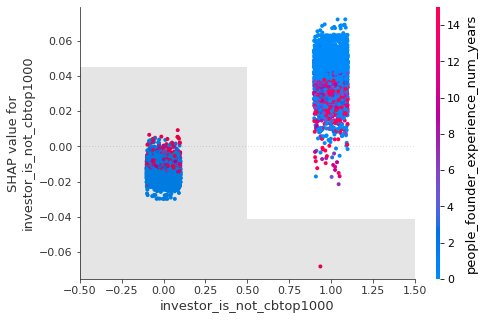

In [75]:
for feature in X_train.columns:
    shap.plots.scatter(shap_values[:,feature],color=shap_values)

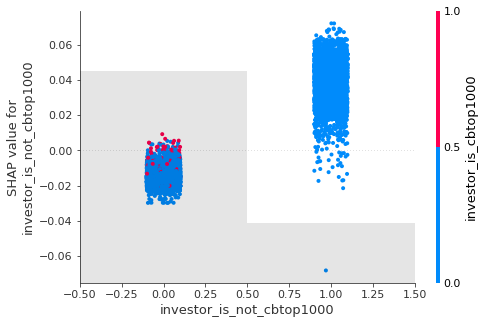

In [80]:
shap.plots.scatter(shap_values[:,'investor_is_not_cbtop1000'],color = (shap_values[:,'investor_is_cbtop1000']))

In [ ]:
shap.summary_plot(sha)

In [ ]:
shap.plots.bar(shap_values.abs.max(0))

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.heatmap(shap_values[:10000])